In [33]:
import sys

sys.path.append("../src/")

In [34]:
import pandas
import copy

from datasets import load_dataset

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler
import pandas
import numpy as np
import seaborn

from transformations import center_and_scale

# show all elements of a dataframe
# pandas.set_option("display.max_rows", None)
pandas.set_option("display.max_columns", None)

# Clustering
Often, we think of data in terms of groups, e.g., "People with a smoking habit and over 60 are more likely to die of Covid."
Sometimes these groups are given, and we can assign each record to a group.
But more often, the question itself is: which are the groups?

## K-means

Clustering algorithm aggregating data in globular clusters. Defined by hyperparameters:
- A predefined number $k$ of clusters
- A distance measure $d$
- A set of initial candidate cluster centroids

## DB-Scan

Density-based clustering algorithm aggregating data in dense clusters. Defined by two hyperparameters:
- A density $\varepsilon$, defining the density radius
- A distance measure $d$
- A minimum cluster size $l$, defining the minimum number of points to define core points

## Hierarchical clustering

A multi-level clustering. Defined by:

- A distance measure $d$
- A trimming policy $\rho$, extracting a clustering from the hierarchy 

Two additional libraries:
- [pyclustering](https://pypi.org/project/pyclustering/)
- [densired](https://github.com/PhilJahn/DENSIRED)

The latter is quite experimental.

### Hyperparameter search

Several algorithms requires us to look for a set of hyperparameters within a large hyperparameter space. We can explore it through several search strategies, among which we have:
- grid search: tries every possible combination of hyperparameters
- randomized search: tries a randomly selected subset of hyperparameters

In [35]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
numeric_dataset = dataset.select_dtypes(include="number").iloc[:10000]
normalized_df, normalization_scalers_df = center_and_scale(numeric_dataset)

Using the latest cached version of the dataset since mstz/adult couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'income' at /Users/lorenzomannocci/.cache/huggingface/datasets/mstz___adult/income/1.0.0/c6dab4788cb6b2e62c4f462063f4f56c78a95180 (last modified on Mon Sep 23 09:16:09 2024).


In [36]:
# computing sample densities for DBScan to avoid arbitrary values
# maximum distance between any two points in the dataset
maximum_distance = abs(normalized_df.max() - normalized_df.min()).sum().item()
average_concentration = normalized_df.shape[0] / maximum_distance


# set model space
base_algorithms = [
    KMeans,
    SpectralClustering,
    DBSCAN,
    AgglomerativeClustering,
    OPTICS
]
base_algorithms_names = [
    "kmeans",
    "spectral",
    "dbscan",
    "agglomerative",
    "optics"
]
# what hyperparameters does each model have?
hyperparameters_per_algorithm = [
    {
        "n_clusters": list(range(2, 8)) + [16, 32],
        "max_iter": [10],
        "random_state": [RANDOM_STATE]
    },
    {
        "n_clusters": list(range(2, 8)) + [16, 32],
        "random_state": [RANDOM_STATE]
    },
    {
        "eps": average_concentration * np.array([10, 5, 2.5, 1, 0.1, 0.01, 0.0001])
    },
    {
        "n_clusters": list(range(2, 8)) + [16, 32]
    },
    {
        "p": list(range(1, 4))
    }
]

results_per_algorithm = list()
fit_models = list()
clusterings = list()
for algorithm, algorithm_name, hyperparameters in zip(base_algorithms, base_algorithms_names, hyperparameters_per_algorithm):
    # setup search for this algorithm
    sampled_hyperparameters = list(ParameterSampler(
        copy.deepcopy(hyperparameters),
        n_iter=5,  # how many configurations to sample?
        random_state=RANDOM_STATE
    ))
    models = [
        algorithm(**selected_hyperparameters).fit(normalized_df.values)
        for selected_hyperparameters in sampled_hyperparameters
    ]
    clusterings += [
        model.labels_
        for model in models
    ]
    fit_models += models

    # store configurations
    for fit_model, selected_hyperparameters in zip(models, sampled_hyperparameters):
        selected_hyperparameters["algorithm"] = algorithm_name
        if hasattr(fit_model, "n_clusters"):
            selected_hyperparameters["n_clusters"] = fit_model.n_clusters
        else:
            selected_hyperparameters["n_clusters"] = selected_hyperparameters.get("n_clusters", 0)
    results_per_algorithm += sampled_hyperparameters

results_df = pandas.DataFrame.from_records(results_per_algorithm)
results_df.loc[:, "random_state"] = RANDOM_STATE

# clean extra hyperparameters
results_df.loc[results_df["max_iter"].isna(), "max_iter"] = -1
results_df.loc[results_df["eps"].isna(), "eps"] = -1
results_df.loc[results_df["p"].isna(), "p"] = -1

results_df = results_df.astype({"n_clusters": int, "random_state": int, "p": int})
results_df

/Users/lorenzomannocci/anaconda3/envs/dm/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,random_state,n_clusters,max_iter,algorithm,eps,p
0,42,3,10.0,kmeans,-1.000000,-1
1,42,7,10.0,kmeans,-1.000000,-1
2,42,2,10.0,kmeans,-1.000000,-1
3,42,32,10.0,kmeans,-1.000000,-1
4,42,4,10.0,kmeans,-1.000000,-1
5,42,3,-1.0,spectral,-1.000000,-1
6,42,7,-1.0,spectral,-1.000000,-1
7,42,2,-1.0,spectral,-1.000000,-1
8,42,32,-1.0,spectral,-1.000000,-1
9,42,4,-1.0,spectral,-1.000000,-1


## Evaluation

## Silhouette score

In [37]:
silhouette_per_model = [
    silhouette_score(normalized_df, clustering) if len(set(clustering)) > 1 else -1
    for clustering in clusterings
]
results_df.loc[:, "silhouette"] = silhouette_per_model
results_df = results_df.sort_values(by="silhouette", ascending=False)
results_df

,random_state,n_clusters,max_iter,algorithm,eps,p,silhouette
7,42,2,-1.0,spectral,-1.000000,-1,0.768663
5,42,3,-1.0,spectral,-1.000000,-1,0.493018
2,42,2,10.0,kmeans,-1.000000,-1,0.480111
9,42,4,-1.0,spectral,-1.000000,-1,0.452431
6,42,7,-1.0,spectral,-1.000000,-1,0.447825
0,42,3,10.0,kmeans,-1.000000,-1,0.331618
15,42,3,-1.0,agglomerative,-1.000000,-1,0.325767
17,42,2,-1.0,agglomerative,-1.000000,-1,0.317243
19,42,4,-1.0,agglomerative,-1.000000,-1,0.311460
12,42,0,-1.0,dbscan,1.704806,-1,0.291822


## Cohesion

In [38]:
from scipy.spatial.distance import cdist


clusterings_cohesions = list()
for i, clustering in enumerate(clusterings):
    clusters_indices = [np.argwhere(clustering == target_cluster).squeeze()
                        for target_cluster in np.unique(clustering)]
    centroids = [normalized_df.values[cluster].mean(axis=0)
                 for cluster in clusters_indices]
    mean_distances = [sum(cdist([centroid], normalized_df.values[indices]).squeeze()).item()
                      for centroid, indices in zip(centroids, clusters_indices) if centroid.ndim > 0]
    clusterings_cohesions.append(mean_distances)

summed_cohesions = [sum(cohesion) for cohesion in clusterings_cohesions]
results_df.loc[:, "cohesion"] = summed_cohesions
results_df.sort_values(by="silhouette")

,random_state,n_clusters,max_iter,algorithm,eps,p,silhouette,cohesion
11,42,0,-1.0,dbscan,852.402815,-1,-1.000000,17568.993114
13,42,0,-1.0,dbscan,426.201408,-1,-1.000000,17606.527973
14,42,0,-1.0,dbscan,17.048056,-1,-1.000000,18079.229361
10,42,0,-1.0,dbscan,1704.805631,-1,-1.000000,17229.192541
22,42,0,-1.0,optics,-1.000000,3,-0.420668,10449.850892
20,42,0,-1.0,optics,-1.000000,1,-0.416850,20201.915563
21,42,0,-1.0,optics,-1.000000,2,-0.404080,15640.048329
18,42,32,-1.0,agglomerative,-1.000000,-1,0.165861,18725.843766
3,42,32,10.0,kmeans,-1.000000,-1,0.189122,22911.944679
16,42,7,-1.0,agglomerative,-1.000000,-1,0.196663,22911.944679


<Axes: xlabel='n_clusters', ylabel='silhouette'>

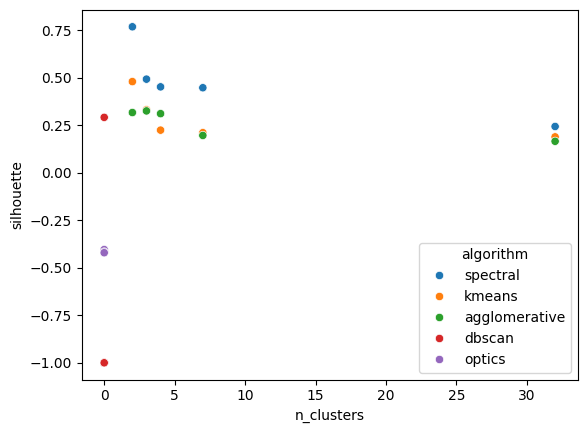

In [39]:
import seaborn


seaborn.scatterplot(
    results_df,
    x="n_clusters",
    y="silhouette",
    hue="algorithm"
)

# How do clusters relate with original data?

For simplicity, here let us take one cluster.

In [40]:
reference_clustering_index = 19
reference_clustering = clusterings[reference_clustering_index]
clustering_dataframe = pandas.DataFrame(reference_clustering, columns=["clustering"])
dataset_with_clustering = pandas.concat((dataset, clustering_dataframe), axis="columns")

# for simplicity, only show a subset of the data
dataset_with_clustering = dataset_with_clustering.iloc[:reference_clustering.size, :]

dataset_with_clustering = dataset_with_clustering.astype({"clustering": int})
dataset_with_clustering.head()

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,over_threshold,clustering
0,43,0.0,0.0,10,34278,35,Married-civ-spouse,United-States,Sales,White,Husband,True,Private,0,0
1,23,0.0,0.0,3,244698,35,Never-married,Mexico,Farming-fishing,White,Other-relative,True,Private,0,0
2,39,0.0,0.0,10,118286,40,Married-civ-spouse,United-States,Sales,Black,Husband,True,Private,0,0
3,35,0.0,0.0,9,126675,46,Divorced,?,Craft-repair,White,Not-in-family,True,Private,0,0
4,66,0.0,0.0,13,28367,99,Married-civ-spouse,United-States,Priv-house-serv,White,Other-relative,True,Private,0,0


In [41]:
clusters_sizes = np.unique(reference_clustering, return_counts=True)[1]
average_worker_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "mean",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
average_worker_per_cluster.loc[:, "cluster_size"] = clusters_sizes
std_worker_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "std",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
std_worker_per_cluster.loc[:, "cluster_size"] = clusters_sizes


average_worker_per_cluster

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold,cluster_size
clustering,,,,,,,,
0,36.748719,155.364446,0.325196,9.615187,191446.400998,39.008632,0.005395,7414
1,44.117479,2362.060649,0.000000,11.571156,183825.833811,44.931232,0.998567,2094
2,41.751131,0.000000,1899.176471,11.067873,182131.061086,43.690045,0.518100,442
3,46.620000,99999.000000,0.000000,12.800000,186226.120000,51.000000,1.000000,50


In [42]:
std_worker_per_cluster

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold,cluster_size
clustering,,,,,,,,
0,13.967997,858.949548,13.348108,2.440694,107909.928401,12.533260,0.073259,7414
1,10.584294,5194.817686,0.000000,2.326328,95007.662937,10.511071,0.037832,2094
2,12.401688,0.000000,318.879068,2.693725,94274.618510,12.755376,0.500239,442
3,11.201111,0.000000,0.000000,2.466097,94760.674403,14.395294,0.000000,50


**Observation.** What do clusters represent?

1. Younger population with some debt, lower education, and mig to high-mid workload. Extremely unlikely to be above threshold.
2. Older population with no debt, solid capital, and higher education. Overwhelmingly  above threshold.
3. Small set of middle-aged people with no savings, crushing debt, although they have a high education level and tend to work as much as other groups.
4. Small set of high earners, highly educated, with a high number of work hours. Overwhelmingly above threshold.

### What are the features relevant to clustering?

In other words, how different are centroids?

In [43]:
average_worker_per_cluster.std().sort_values()

over_threshold               0.474480
education                    1.317914
age                          4.206474
hours_worked_per_week        4.937878
capital_loss               949.534048
cluster_size              3393.626183
final_weight              4056.918694
capital_gain             49591.662996
dtype: float64

**Observation** Clusters really themselves through `capital_gain`, `capital_loss`, and `final_weight`.

Note: to uniform analysis, leverage a normalized version of the dataset.

### How do cluster differ from the whole dataset?

In [44]:
columns_of_interest = list(average_worker_per_cluster.columns)[:-1]
average_worker_per_cluster.std().divide(dataset[columns_of_interest].std()).sort_values()

final_weight             0.038318
age                      0.306345
hours_worked_per_week    0.398381
education                0.513680
over_threshold           1.112109
capital_loss             2.373984
capital_gain             6.590788
cluster_size                  NaN
dtype: float64

# Algorithms Step By Step

## Clustering Objective
Grouping a set of instances such that the instances in the same cluster are more ***similar*** (in some sense) to each other than to those in other clusters.  
The result of a clustering algorithm is a ***clustering***, that is a set of clusters.
Clustering is an ***unsupervised*** task, i.e., the real cluster partitioning is unknown.  

## Different Types of Clusterings and Clusters

Principal Types of Clustering:
* **Partitional Clustering:** division into non-overlapping clusters, i.e., each instance is only in one cluster
* Hierarchical Clustering: set of nested clusters organized as a hierarchical tree

Principal Types of Clusters:
* **Center-based:** the calculus is based on a centroid (K-Means)
* **Density-based:** the calculus is based on a concept of neighborhood and density (DBSCAN)

Center-based: <img align="center" src="kmeans.png">
Density-based: <img align="center" src="dbscan.png">

## Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max

In [45]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
num_columns = ['age', 'capital_gain', 'capital_loss', 'education', 'final_weight','hours_worked_per_week']
cat_columns = ['marital_status', 'native_country', 'occupation', 'race', 'relationship', 'is_male', 'workclass', 'over_threshold']
df = dataset.iloc[0:10000]
numeric_dataset = df[num_columns]
cat_dataset = df[cat_columns]

In [46]:
numeric_dataset.head()

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week
0,43,0.0,0.0,10,34278,35
1,23,0.0,0.0,3,244698,35
2,39,0.0,0.0,10,118286,40
3,35,0.0,0.0,9,126675,46
4,66,0.0,0.0,13,28367,99


In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(numeric_dataset)
X = scaler.transform(numeric_dataset)

In [48]:
pandas.DataFrame(scaler.inverse_transform(scaler.transform(numeric_dataset)), columns=numeric_dataset.columns)

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week
0,43.0,0.0,0.0,10.0,34278.0,35.0
1,23.0,0.0,0.0,3.0,244698.0,35.0
2,39.0,0.0,0.0,10.0,118286.0,40.0
3,35.0,0.0,0.0,9.0,126675.0,46.0
4,66.0,0.0,0.0,13.0,28367.0,99.0
...,...,...,...,...,...,...
9995,30.0,0.0,0.0,11.0,609789.0,40.0
9996,50.0,0.0,0.0,13.0,123374.0,50.0
9997,47.0,0.0,0.0,9.0,185400.0,40.0
9998,20.0,0.0,0.0,9.0,122244.0,28.0


# K-Means

## The Algorithm in a Nutshell

**Objective:** Clusters the data into $k$ groups.
* **Init step:** Select k points at random as cluster centers.
* **Assignment step:** Assign each instance to the cluster with the closest mean according to the distance function.
* **Update step**: Calculate the new means to be the centroids of the instances in the new clusters.
* ***Repeat*** steps 2 and 3 until the assignment no longer change.

There is no guarantee that the optimum is found using this algorithm.

> Tan, P. N. (2006). Introduction to data mining. Pearson Education India.

Running [example](http://matlaspisa.isti.cnr.it:5055/K-Means)
Wikipedia [link](https://en.wikipedia.org/wiki/K-means_clustering)

## K-Means Problems

* Initial Centroids
* Number of clusters

## K-Means in Python  ([sklearn](http://scikit-learn.org/stable/modules/clustering.html#k-means))

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Parameters:
* **n_clusters** (default 8): The number of clusters
* **n_init** (default 10): Number of time k-means will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter** (default 300): Maximum number of iterations of the k-means algorithm for a single run.

In [50]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=5, n_init=10)

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

Labels

In [51]:
kmeans.labels_[:5]

array([1, 4, 3, 4, 3], dtype=int32)

Observing the size of each cluster

In [52]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 441, 2459,   50, 3095, 3955]))

Visualization of the clustering in two dimensions.

<Axes: xlabel='age', ylabel='final_weight'>

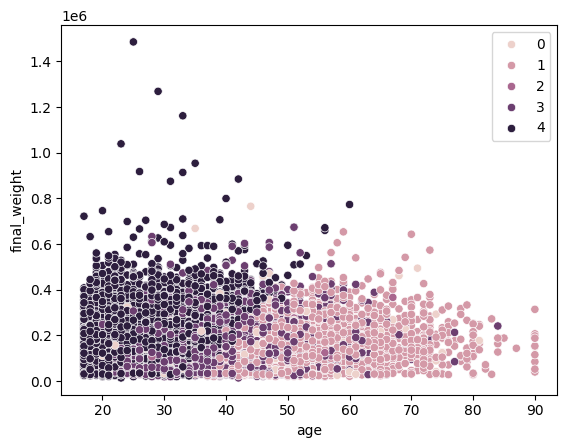

In [53]:
seaborn.scatterplot(data=numeric_dataset, x="age", y="final_weight", hue=kmeans.labels_)

Centers

In [54]:
kmeans.cluster_centers_

array([[ 0.22981848, -0.14810647,  4.587545  ,  0.37567424, -0.06902925,
         0.2564021 ],
       [ 1.13830409, -0.06298475, -0.21016724, -0.50763161, -0.21926902,
        -0.27600405],
       [ 0.59218004, 13.19711783, -0.21249478,  1.04877264, -0.03042645,
         0.84342251],
       [ 0.05061282,  0.01681074, -0.21172114,  0.84880498, -0.23118574,
         0.66557208],
       [-0.7829471 , -0.12434299, -0.21249478, -0.40297466,  0.32587164,
        -0.38813184]])

In [55]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

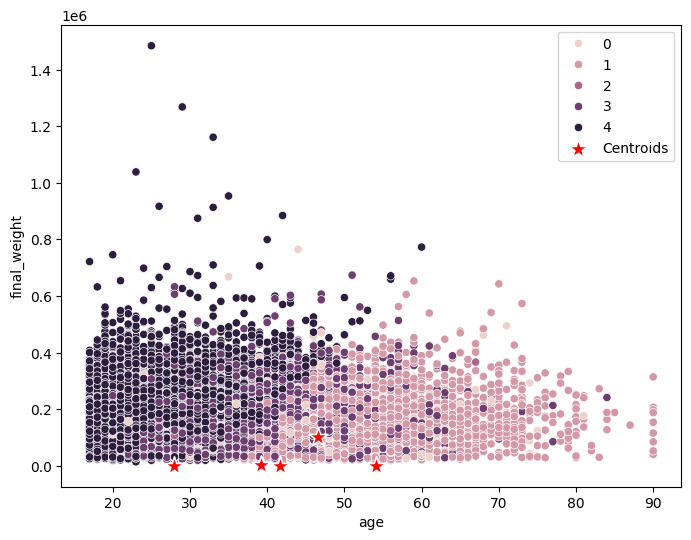

In [56]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="age", y="final_weight", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,0], y=centers[:, 1], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('age')
plt.ylabel('final_weight')

# Display the plot
plt.legend()
plt.show()

Visualization of clusters centers by means of parallel coordinates

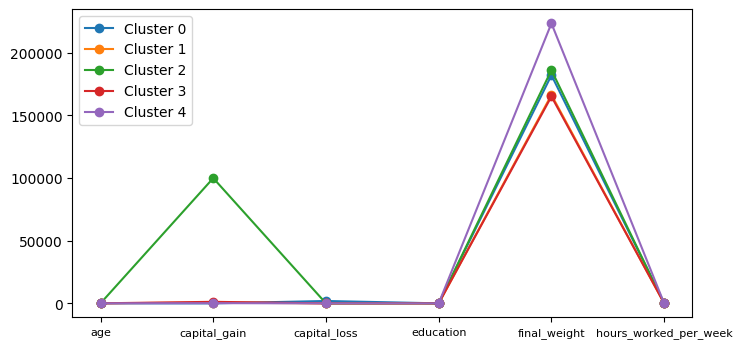

In [57]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(numeric_dataset.columns)), numeric_dataset.columns, fontsize=8)
plt.legend(fontsize=10)
plt.show()

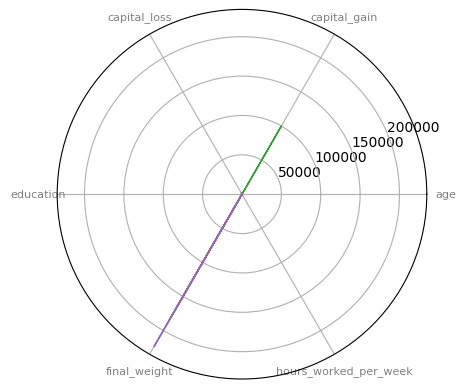

In [58]:
from math import pi
 
# number of variable
N = len(numeric_dataset.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the spider plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], numeric_dataset.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

SSE and Clustering Validation

In [59]:
from sklearn import metrics

print('SSE %s' % kmeans.inertia_) # cohesion, lower value better clustering (error minimization)
print('Separation %s' % metrics.davies_bouldin_score(X, kmeans.labels_)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))
# Silhouette. The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster

SSE 29290.619764225397
Separation 1.1368752406325746
Silhouette 0.2172897200351038


In [60]:
cross_df = pandas.crosstab(kmeans.labels_,df['marital_status'])
cross_df

marital_status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
row_0,,,,,,,
0,37,0,290,4,92,10,8
1,472,1,1432,36,205,89,224
2,5,1,40,0,4,0,0
3,431,4,1721,32,809,67,31
4,386,5,1159,52,2209,119,25


In [61]:
cross_df = pandas.crosstab(kmeans.labels_,df['workclass'])
cross_df

workclass,?,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
row_0,,,,,,,,
0,19,16,32,283,31,44,16,0
1,210,78,161,1573,88,254,92,3
2,2,1,2,26,8,10,1,0
3,48,117,297,1964,194,321,153,1
4,298,73,188,3063,44,165,124,0


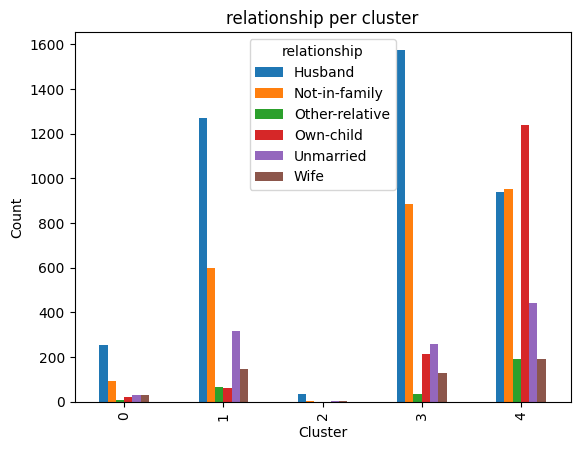

In [62]:
cross_df = pandas.crosstab(kmeans.labels_, df['relationship'])

cross_df.plot(kind='bar', stacked=False, 
                   title='relationship per cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Knee Method to estimate the best K

In [63]:
sse_list = list()
max_k = 40
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

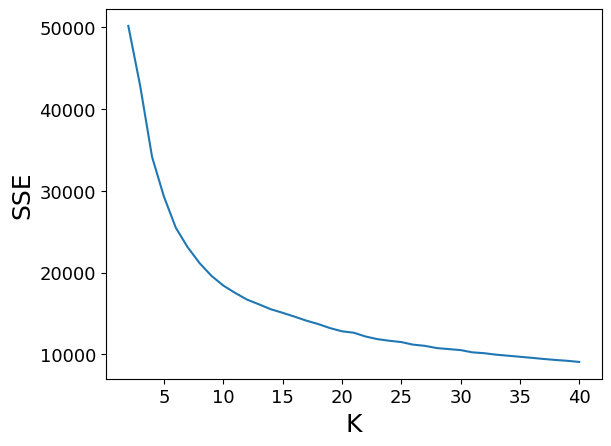

In [64]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=18)
plt.xlabel('K', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

# DBSCAN

## The Algorithm in a Nutshell

* A point is a **core** if it has more than minPts points within eps
* A point is a **border** if it has less than minPts points within eps but one of its neighboors is a core point
* A **noise** point is neither a core or a border point


1. Label all points as core, border or noise points
1. Eliminate noise points.
1. Put an edge between all core points that are within eps of each other
1. Make each group of connected core points into a separate cluster.
1. Assign each border point to one of the clusters of its associated core points.

> Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996, August). A density-based algorithm for discovering clusters in large spatial databases with noise. In Kdd (Vol. 96, No. 34, pp. 226-231).

Running [example](http://matlaspisa.isti.cnr.it:5055/Dbscan)  
Wikipedia [link](https://en.wikipedia.org/wiki/DBSCAN)

## DBSCAN Problems

* Parameter tuning
* Does not recognize different densities

## DBSCAN in Python ([sklearn](http://scikit-learn.org/stable/modules/clustering.html#dbscan))

In [65]:
from sklearn.cluster import DBSCAN

Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [66]:
# MinPts = 2·D
# Eps->Elbow Method
dbscan = DBSCAN(eps=1.7, min_samples=130)
dbscan.fit(X)

DBSCAN(eps=1.7, min_samples=130)

Output:
* **labels_**: Cluster labels for each point in the dataset. Noisy samples are given the label -1.

Labels

In [67]:
dbscan.labels_[:5]

array([ 0,  0,  0,  0, -1])

Observing the size of each cluster

In [68]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 238, 9407,  355]))

In [69]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 1])

Visualization of the clustering in two dimensions.

<Axes: xlabel='age', ylabel='final_weight'>

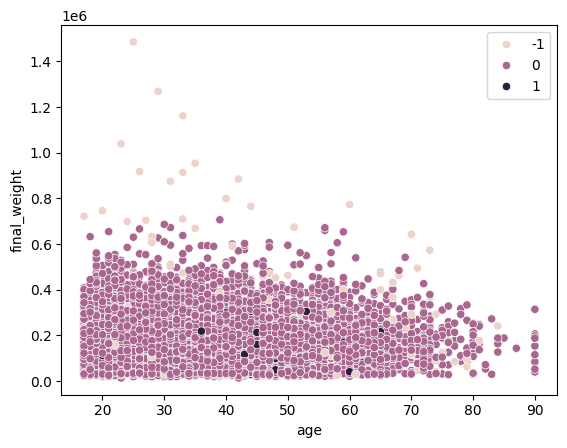

In [70]:
seaborn.scatterplot(data=numeric_dataset, x="age", y="final_weight", hue=dbscan.labels_, legend='full')

Clustering Validation

In [71]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.5044093518395929


Knee Method to estimate the best eps

In [72]:
from scipy.spatial.distance import pdist, squareform

In [73]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

(49995000,)
(10000, 10000)


In [74]:
k = 130
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

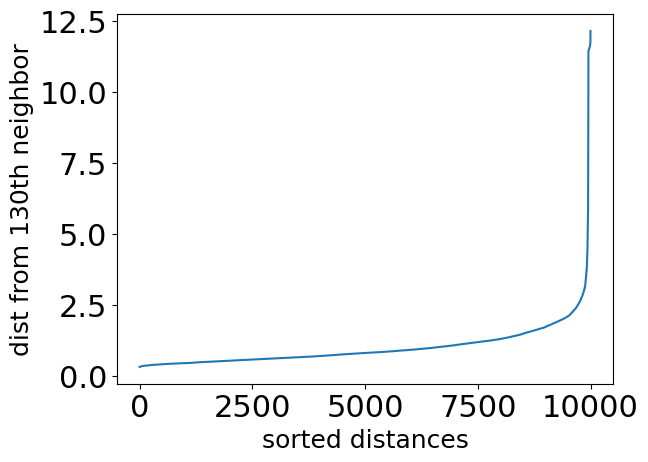

In [75]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

## Hierarchical clustering 

#### There are 2 kinds of hierarchical clustering: agglomerative and divisive. In the following, there are some example of the agglomerative clustering using scipy. The scipy library allows for hierachical clusters by exploiting the linkage function and then the dendrogram. The first function, given a matrix of pair-wise distances, computes the agglomerative clustering. There are 2 parameters: the method, that can be single, complete, ward, average, weighted, centroids and median, and the metric used to compute the distances, such as euclidean or cosine. Then, with the dendrogram function, it is possible to visualize the result obtained. This kind of clustering is also possible with scikit-learn library, but the dendrogram visualization is not directly available.

In [76]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

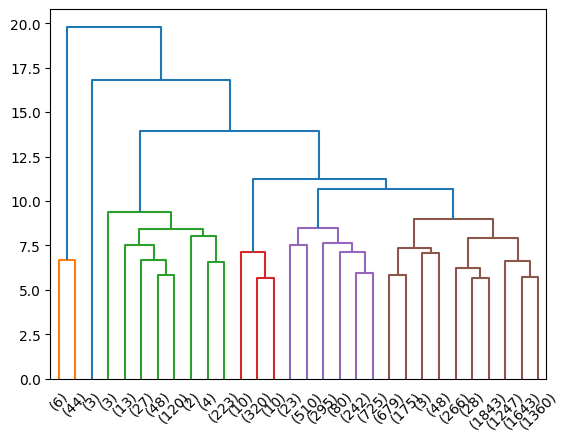

In [77]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=10, truncate_mode='lastp')

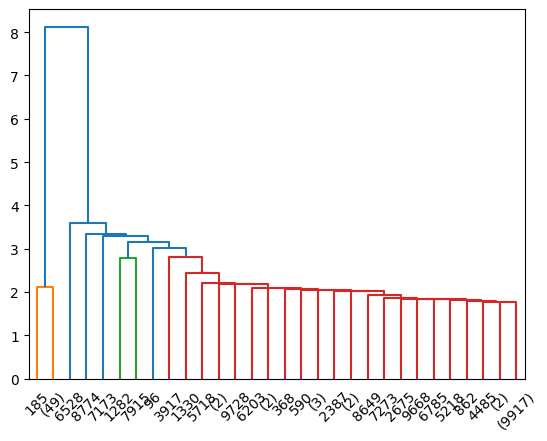

In [78]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=3, truncate_mode='lastp')

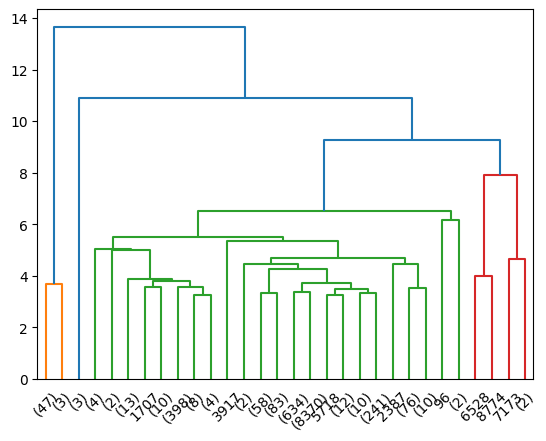

In [79]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=8, truncate_mode='lastp')

In [80]:
#with sciki-learn you have to select the number of clusters you want
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
agg_cluster.fit_predict(X)


array([0, 0, 0, ..., 0, 0, 3])

In [81]:
agg_cluster.labels_

array([0, 0, 0, ..., 0, 0, 3])

<Axes: xlabel='education', ylabel='capital_loss'>

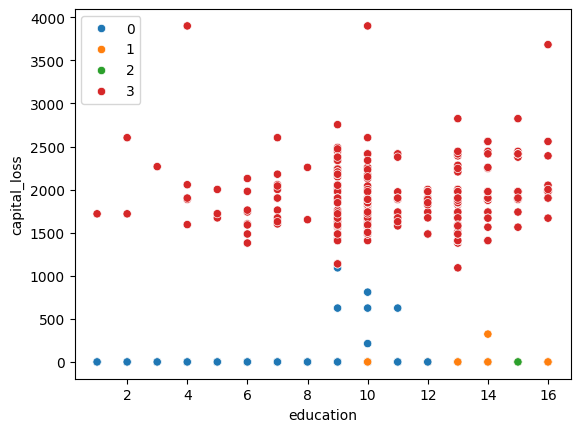

In [201]:
seaborn.scatterplot(data=numeric_dataset, x="education", y="capital_loss", hue=agg_cluster.labels_, legend='full', palette=seaborn.color_palette(n_colors=len(np.unique(agg_cluster.labels_))))
